In [1]:
from os import sys
sys.path.append("../../meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu

sm = reload(sm)

In [3]:
#Setting where base neuron is
segment_id = 97338459408083949

current_mesh_file = f"/notebooks/neuron_mesh_tools/test_neurons/spine_detection/{segment_id}_inhibitory_9.off"


# **** Phase 1 ****

# Starting from the very beginning of a neuron mesh

In [4]:
current_neuron = trimesh.load_mesh(current_mesh_file)

In [5]:
sk.graph_skeleton_and_mesh(main_mesh_verts=current_neuron.vertices,
                          main_mesh_faces=current_neuron.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Doing the soma detection

In [73]:
total_soma_list_sdf

[0.886955]

In [6]:
soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 1250.0 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 953
xvfb-run -n 953 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/neuron_97338459408083949.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/neuron_97338459408083949_decimated.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/decimation_meshlab_25663679.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(22908, 3), faces.shape=(46098, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(22908, 3), faces.shape=(46098, 3))>
pre_largest_mesh_path = /notebooks/neuron_mesh_tools/meshAfterParty/

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


Total found significant pieces AFTER Poisson = [<trimesh.Trimesh(vertices.shape=(20279, 3), faces.shape=(40554, 3))>]
----- working on mesh after poisson #0: <trimesh.Trimesh(vertices.shape=(20279, 3), faces.shape=(40554, 3))>
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 8360
xvfb-run -n 8360 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/neuron_97338459408083949_decimated_largest_piece_poisson_largest_inner.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/neuron_97338459408083949_decimated_largest_piece_poisson_largest_inner_decimated.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/97338459408083949/decimation_meshlab_25620645.mls
done exporting decimated mesh: neuron_97338459408083949_decimated_largest_piece_poisson_largest_inner.off
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mes

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/neuron_mesh_tools/meshAfterParty/development/Poisson_temp/neuron_750849.off
removed temporary output file: /notebooks/neuron_mesh_tools/meshAfterParty/development/Poisson_temp/neuron_750849_poisson.off
/notebooks/neuron_mesh_tools/meshAfterParty/development/Poisson_temp/poisson_733307.mls is being deleted....
Inside sphere validater: ratio_val = 2.4891036735954963



 Total time for run = 30.091021299362183


# At this point assume that there are somas (if not would just skip to the limb skeleton stuff)

In [7]:
# Visualizing the somas: 
total_soma = tu.combine_meshes(soma_mesh_list)
soma_meshes = total_soma
sk.graph_skeleton_and_mesh(main_mesh_verts=soma_meshes.vertices,
                          main_mesh_faces=soma_meshes.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [8]:
# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Soma List = [<trimesh.Trimesh(vertices.shape=(1853, 3), faces.shape=(3631, 3))>]
soma_mesh_list_centers = [array([985862.54193199, 903030.29881274, 798091.55828386])]


# getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

In [9]:
main_mesh_total = current_neuron
sig_th_initial_split=15

#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list_centers,
                                        split_meshes)

containing_mesh_indices

# total split meshes = 9


{0: 0}

In [10]:
# filtering away any of the inside floating pieces: 
sm = reload(sm)
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """
    
    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]

    
print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")

There were 8 pieces found after size threshold
# of non soma touching seperate meshes = 4
# of inside pieces = 4
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


# Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

In [72]:
prelim_soma_mesh = current_neuron.submesh([soma_faces[soma_face_components[0]]],append=True)
sk.graph_skeleton_and_mesh(other_meshes=[prelim_soma_mesh])

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [69]:
soma_faces

array([  7991,  37947,  38874, ..., 185962, 185963, 185965])

In [ ]:
soma_faces[soma_face_components] will tell the original soma idx

In [11]:
from importlib import reload
sm = reload(sm)
tu = reload(tu)

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


soma_faces[soma_face_components] will tell the original soma idx

"""
limb_threshold = 2000

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print("\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)
    
    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    soma_meshes = current_mesh.submesh([soma_faces],append=True)
    
    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True)
    
    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)
   
    
    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces
    
    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes
    
    
    soma_to_piece_connectivity = dict()
    for i,curr_soma in enumerate(seperate_soma_meshes):
        connected_mesh_pieces,connected_mesh_pieces_vertices  = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces
    
    
    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")
soma_touching_mesh_data



----Working on soma-containing mesh piece {z}----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(45222, 3), faces.shape=(90459, 3))>, <trimesh.Trimesh(vertices.shape=(26265, 3), faces.shape=(52532, 3))>, <trimesh.Trimesh(vertices.shape=(10513, 3), faces.shape=(21031, 3))>]
There were 3 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(45222, 3), faces.shape=(90459, 3))>, <trimesh.Trimesh(vertices.shape=(26265, 3), faces.shape=(52532, 3))>, <trimesh.Trimesh(vertices.shape=(10513, 3), faces.shape=(21031, 3))>]
Total Time for soma mesh cancellation = 0.383
# of insignificant_limbs = 0 with trimesh : []


{0: {'branch_meshes': [<trimesh.Trimesh(vertices.shape=(45222, 3), faces.shape=(90459, 3))>,
   <trimesh.Trimesh(vertices.shape=(26265, 3), faces.shape=(52532, 3))>,
   <trimesh.Trimesh(vertices.shape=(10513, 3), faces.shape=(21031, 3))>],
  'soma_meshes': array([<trimesh.Trimesh(vertices.shape=(11064, 3), faces.shape=(21944, 3))>],
        dtype=object),
  'soma_to_piece_connectivity': {0: [0, 1, 2]}}}

# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***

# Working on the Actual skeleton of all of the branches

In [12]:
sk = reload(sk)
xu = reload(xu)

import time
global_start_time = time.time()

for j,(soma_containing_mesh_idx,mesh_data) in enumerate(soma_touching_mesh_data.items()):
    print(f"\n-- Working on Soma Continaing Mesh {j}--")
    current_branches = mesh_data["branch_meshes"]
    
    #skeletonize each of the branches
    total_skeletons = []
    
    for z,branch in enumerate(current_branches):
        print(f"\n    -- Working on branch {z}--")
        curren_skeleton = sk.skeletonize_connected_branch(branch)
        #clean the skeleton
            # --------  Doing the cleaning ------- #
        clean_time = time.time()
        filter_end_node_length=5000,
        new_cleaned_skeleton = sk.clean_skeleton(curren_skeleton,
                                distance_func=sk.skeletal_distance,
                          min_distance_to_junction=filter_end_node_length,
                          return_skeleton=True,
                          print_flag=False)
        print(f"    Total time for skeleton and cleaning of branch {z}: {time.time() - clean_time}")
        if len(new_cleaned_skeleton) == 0:
            raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")
        total_skeletons.append(new_cleaned_skeleton)
    
    soma_touching_mesh_data[j]["branch_skeletons"] = total_skeletons
    
print(f"Total time for skeletonization = {time.time() - global_start_time}")


-- Working on Soma Continaing Mesh 0--

    -- Working on branch 0--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 1842
xvfb-run -n 1842 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_72830.mls
-----Time for Screened Poisson= 20.192862510681152


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma

     Starting Calcification
Before mesh subtraction number of skeleton edges = 1759
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 90459



Total Mesh subtraction time = 21.0427



len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.5571756362915039
The process was using a temp folder
Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 0: 5.585726737976074

    -- Working on branch 1--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP

LEAVING LOOP, MESH VALIDATED
Using port = 5477
xvfb-run -n 5477 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_377460.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


-----Time for Screened Poisson= 11.79577898979187
     Starting Calcification
Before mesh subtraction number of skeleton edges = 1070
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 52532


No adjacent faces detected! Did you merge vertices?



Total Mesh subtraction time = 13.4872



len_subgraphs AT BEGINNING of the loop


all graph is one component!
Total time for skeleton stitching = 0.3204689025878906
The process was using a temp folder

Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 1: 1.1139330863952637

    -- Working on branch 2--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP

LEAVING LOOP, MESH VALIDATED
Using port = 2666
xvfb-run -n 2666 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_966971.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


-----Time for Screened Poisson= 7.9032206535339355
     Starting Calcification
Before mesh subtraction number of skeleton edges = 345
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 21031



Total Mesh subtraction time = 1.932



len_subgraphs AT BEGINNING of the loop


all graph is one component!
Total time for skeleton stitching = 0.06837630271911621
The process was using a temp folder

Using Distance measure skeletal_distance



    Total time for skeleton and cleaning of branch 2: 0.1916790008544922
Total time for skeletonization = 100.6843810081482


In [13]:
# save off the data and rename it for use in phase 2
# Save our current
print("hello")
saved_file = f"./soma_mesh_data/soma_touching_mesh_data_{segment_id}.npz"
np.savez(saved_file,soma_touching_mesh_data=soma_touching_mesh_data)
current_mesh_data = soma_touching_mesh_data

hello


# Lets have an alert if there was more than one soma disconnected meshes

In [14]:
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

# ******* Phase 2 ********

# Importing and visualizing the preprocessed data (for sped up testing)

In [15]:
# saved_file = "../../Platinum_Compartment/soma_touching_mesh_data.npz"
saved_file = f"./soma_mesh_data/soma_touching_mesh_data_{segment_id}.npz"
current_mesh_data = nu.load_dict(saved_file)

In [16]:
# visualizing the original neuron
current_neuron = trimesh.load_mesh(current_mesh_file)
sk.graph_skeleton_and_mesh(main_mesh_verts=current_neuron.vertices,
                          main_mesh_faces=current_neuron.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [17]:
# visualizing the somas that were extracted
soma_meshes = tu.combine_meshes(current_mesh_data[0]["soma_meshes"])
sk.graph_skeleton_and_mesh(main_mesh_verts=soma_meshes.vertices,
                          main_mesh_faces=soma_meshes.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [18]:
# # Visualize the extracted branches
# # visualize all of the branches and the meshes
# sk.graph_skeleton_and_mesh(other_meshes=list(current_mesh_data[0]["branch_meshes"]) + list(current_mesh_data[0]["soma_meshes"]),
#                           other_meshes_colors="random",
#                            other_skeletons = current_mesh_data[0]["branch_skeletons"],
#                           other_skeletons_colors="random")

# Cleaning each limb through distance and decomposition, checking that all cleaned branches are connected components and then visualizing

In [19]:
skelton_cleaning_threshold = 4001
total_cleaned = []
for j,curr_skeleton_to_clean in enumerate(current_mesh_data[0]["branch_skeletons"]):
    print(f"\n---- Working on Limb {j} ----")
    start_time = time.time()
    print(f"before cleaning limb size of skeleton = {curr_skeleton_to_clean.shape}")
    distance_cleaned_skeleton = sk.clean_skeleton(
                                                curr_skeleton_to_clean,
                                                distance_func=sk.skeletal_distance,
                                                min_distance_to_junction = skelton_cleaning_threshold,
                                                return_skeleton=True,
                                                print_flag=False) 
    #make sure still connected componet
    distance_cleaned_skeleton_components = nx.number_connected_components(sk.convert_skeleton_to_graph(distance_cleaned_skeleton))
    if distance_cleaned_skeleton_components > 1:
        raise Exception(f"distance_cleaned_skeleton {j} was not a single component: it was actually {distance_cleaned_skeleton_components} components")
        
    print(f"after DISTANCE cleaning limb size of skeleton = {distance_cleaned_skeleton.shape}")
    cleaned_branch = sk.clean_skeleton_with_decompose(distance_cleaned_skeleton)
    
    cleaned_branch_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cleaned_branch))
    if cleaned_branch_components > 1:
        raise Exception(f"cleaned_branch {j} was not a single component: it was actually {cleaned_branch_components} components")
    
    #do the cleanin ghtat removes loops from branches
    print(f"After DECOMPOSITION cleaning limb size of skeleton = {cleaned_branch.shape}")
    print(f"Total time = {time.time() - start_time}")
    total_cleaned.append(cleaned_branch)
    
current_mesh_data[0]["branch_skeletons_cleaned"] = total_cleaned


---- Working on Limb 0 ----
before cleaning limb size of skeleton = (2130, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (2130, 2, 3)
After DECOMPOSITION cleaning limb size of skeleton = (2130, 2, 3)
Total time = 1.1753277778625488

---- Working on Limb 1 ----
before cleaning limb size of skeleton = (1216, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (1216, 2, 3)
type(branch_subgraph) = <class 'networkx_utils.GraphOrderedEdges'>
in remove edge
After DECOMPOSITION cleaning limb size of skeleton = (1215, 2, 3)
Total time = 0.526533842086792

---- Working on Limb 2 ----
before cleaning limb size of skeleton = (420, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (4

In [20]:
# checking all cleaned branches are connected components

for k,cl_sk in enumerate(current_mesh_data[0]["branch_skeletons"]): 
    n_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cl_sk)) 
    if n_components > 1:
        raise Exception(f"Original limb {k} was not a single component: it was actually {n_components} components")
    
for k,cl_sk in enumerate(current_mesh_data[0]["branch_skeletons_cleaned"]): 
    n_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cl_sk)) 
    if n_components > 1:
        raise Exception(f"Cleaned limb {k} was not a single component: it was actually {n_components} components")

In [21]:
# visualize all of the branches and the meshes
sk.graph_skeleton_and_mesh(other_meshes=list(current_mesh_data[0]["branch_meshes"]) + list(current_mesh_data[0]["soma_meshes"]),
                          other_meshes_colors="random",
                           other_skeletons = current_mesh_data[0]["branch_skeletons_cleaned"],
                          other_skeletons_colors="random",
                          mesh_alpha=0.15)

# Decomposing of limbs into branches and finding mesh correspondence (using adaptive mesh correspondence followed by a water fill for conflict and empty faces), checking that it went well with no empty meshes and all connected component graph when constructed from branches, plus visualization at end

In [22]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
from tqdm.notebook import tqdm
import time
import itertools

start_time = time.time()

limb_correspondence = dict()
soma_containing_idx= 0

total_branch_meshes = []
total_branch_skeletons = []

empty_submeshes = []
for soma_containing_idx in current_mesh_data.keys():
    for limb_idx,curr_limb_mesh in enumerate(current_mesh_data[soma_containing_idx]["branch_meshes"]):
        print(f"Working on limb #{limb_idx}")
        limb_correspondence[limb_idx] = dict()
        curr_limb_sk = current_mesh_data[soma_containing_idx]["branch_skeletons_cleaned"][limb_idx]
        curr_limb_branches_sk_uneven = sk.decompose_skeleton_to_branches(curr_limb_sk) #the line that is decomposing to branches
        
        for j,curr_branch_sk in tqdm(enumerate(curr_limb_branches_sk_uneven)):
            limb_correspondence[limb_idx][j] = dict()
            
            
            curr_branch_face_correspondence, width_from_skeleton = cu.mesh_correspondence_adaptive_distance(curr_branch_sk,
                                          curr_limb_mesh,
                                         skeleton_segment_width = 1000)
            
            
            
            if len(curr_branch_face_correspondence) > 0:
                curr_submesh = curr_limb_mesh.submesh([list(curr_branch_face_correspondence)],append=True)
            else:
                curr_submesh = trimesh.Trimesh(vertices=np.array([]),faces=np.array([]))
                
            limb_correspondence[limb_idx][j]["branch_skeleton"] = curr_branch_sk
            limb_correspondence[limb_idx][j]["correspondence_mesh"] = curr_submesh
            limb_correspondence[limb_idx][j]["correspondence_face_idx"] = curr_branch_face_correspondence
            limb_correspondence[limb_idx][j]["width_from_skeleton"] = width_from_skeleton
            
            total_branch_meshes.append(curr_submesh)
            total_branch_skeletons.append(curr_branch_sk)
            
            if len(curr_submesh.faces) == 0:
                empty_submeshes.append(dict(limb_idx=limb_idx,branch_number=j))
            
            
print(f"Total time = {time.time() - start_time}")

Working on limb #0



filtered_measurements = [297.40135723 194.22952427 156.39851326 147.12430961 136.54133823
 230.08956282 269.32155203 246.0786078  173.35577283 165.69794564
 177.31797057 158.29720217 210.08845305 192.94285163 180.27888785
 205.7043479  166.10756952 244.63974564 198.392143  ]
new_threshold = 506.6108183789977


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [348.29663015 339.88113895 311.83275598 227.60687288 182.62653139
 223.64164644 266.19578537 276.11140868 202.40331397  92.0712355
 177.79621289 115.86208977 171.08825207 335.24546517]
new_threshold = 769.6159845267192


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [235.42799109 297.20072635 363.03050967 213.4608419  238.00055827
 209.95213807 190.41873083 245.00132193 245.93567007 291.84452194
 226.58504013 305.86122286 341.21159802 287.62835871 363.0368141
 321.93338499 245.92750071 180.89379551 181.3079521  176.76975393
 269.26179226 223.02693493 164.4511053  300.22541364]
new_threshold = 699.9199186390033



filtered_measurements = [187.58604705  92.81458133 128.26102887 229.33449177  82.31523718
 115.97481714 241.99790463 242.81397404  89.30706292 110.1984416
 158.92117386 175.22028492 127.3936039  149.09684493 161.06234003
 202.88362189 115.61254272 177.137441   220.58220486 218.91315808]
new_threshold = 560.1864009969302


--> Not exactly one containing mesh: []

filtered_measurements = [306.07049244 251.31203544 475.99102184 279.73215562 304.49583456
 367.83456843 461.2011374  409.12014971 271.54676274 285.24795054
 320.74872419 403.34781275 259.11591091 486.87785037 365.03031957
 382.15353003 495.88253519 483.44905698 283.97443939 245.83995101
 264.66893197 494.85627728 377.49698108 331.60762633 304.17488
 294.31679686 275.37523442 223.58542335 265.6771552  303.86761028
 460.83193292 364.50856932 356.83633705 251.91927108 252.55720352
 300.37049753 260.875676   372.88113837 464.47132032 487.15988303
 413.08175998 322.37059192]
new_threshold = 1292.7576156673401


--> Not exactly one containing mesh: []




filtered_measurements = [128.9683088   82.53892881 177.99167234 198.2159066  129.76452021
 277.3120211 ]
new_threshold = 625.2847674606417


--> Not exactly one containing mesh: []

filtered_measurements = [ 99.05885158 112.09977515  71.19426743  75.88222615  64.69889541
  77.59306304  98.0168722  124.64780897  87.52221933  67.06986019
  71.83529211  84.3289914   95.63165005 117.77103868  90.48678684
  69.56422748]
new_threshold = 262.58339459444176


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [24]
branch_touching_number = [24, 1]
most_branch_containing_piece = 0



filtered_measurements = [ 70.7270475  115.36613344 138.57837949 116.71540153  83.34784424
 114.78718892 116.0884331  100.13064127 164.82924945  97.64359283
  82.18504406  78.95909193 116.84901804  67.24627833  91.6595561
 133.15217073 109.51961241 157.26488843 152.08081551  85.75051598
  71.64559365  70.99922229 119.21904864  73.10239204 107.97958821
 105.65813477 131.30665778 164.72755552]
new_threshold = 412.52058487122326



filtered_measurements = [411.8853571  235.09316648 179.65370658 231.13630572 224.87191615
 346.06971267]
new_threshold = 772.4668475948247


--> Not exactly one containing mesh: [0 1]




filtered_measurements = [131.93291749 143.68036544 135.10376988]
new_threshold = 347.2059893095376



filtered_measurements = [319.43524032 296.34483139 326.92648199 321.02648703 382.06036484
 341.18093558 313.22676047 233.24705921 258.73471426 258.23350318
 380.73119928 264.30411499 472.3027687  411.11827998 402.99649367
 315.29780944 254.76151257 294.78284374 393.02166296 401.11725054
 254.49614182 366.87695697 318.85824628 314.74678815 291.87487163]
new_threshold = 973.4836949911887



filtered_measurements = [248.99745665 278.10099184 287.97040701 262.78927967 145.89125464
 131.53143712 172.09549371 264.88125574 266.73466565 236.11037983
 251.92497204 246.94794524 336.75630272 280.04846735 121.56302815
 127.18096769 108.56051578 197.66133948 342.38062969 139.672082
 209.07369104]
new_threshold = 789.6995643582334



filtered_measurements = [320.16435505 257.71505012 259.78619853 211.16319013 198.79361302
 224.72790495 175.51796159 140.65405107 288.32966479 223.48778553
 205.1370409 ]
new_threshold = 553.3724857877131



filtered_measurements = [101.57107259 978.27229401 534.07643258]
new_threshold = 2629.7302872401037



filtered_measurements = [122.28860489 112.62355503 103.66525578 100.67840611  85.78696332]
new_threshold = 223.933578576153



filtered_measurements = [ 77.26066486  90.805314   123.70272508  93.44774277 130.97450279
  98.96830471  94.73835342  94.32679653 150.716427    67.69424404
  52.16983639  71.52338076 106.88525204  80.76602401 144.36772009
 126.8081761   64.36550318  91.90362635]
new_threshold = 327.42276015925654



filtered_measurements = [249.77066963 138.29551855 131.41665055 207.97843376]
new_threshold = 633.4543516742633



filtered_measurements = [254.0004961  270.94699433 360.71239969]
new_threshold = 646.1408021859837



filtered_measurements = [284.73791388 507.69497453 408.12947688 475.50765495 377.9769808
 344.25647034 524.3987562  354.09045128]
new_threshold = 1342.2341608255958



filtered_measurements = [231.1975545  229.83624499 271.30803104 370.88203546 250.57208496
 218.53654661 341.61080919 352.44806792 285.69420124 257.03083363
 279.64789583 313.10055021 209.77044709 249.62641816 282.74657043]
new_threshold = 585.8666695772828



filtered_measurements = [316.64010564 211.36241987 219.24071145 262.53616148 219.32167528
 275.88417007 257.50300085]
new_threshold = 492.87593148038326



filtered_measurements = [282.0784539  270.07591024 351.96403139]
new_threshold = 615.2352851386806



filtered_measurements = [577.83098115 437.881545   369.19800069 547.35386459]
new_threshold = 1030.3967837382984



filtered_measurements = [148.97677203 126.90084284 115.48410927 158.57579014 143.84530786
 114.7613486  123.20340078 156.27881698 183.4715553   96.92690279
 129.96446687  89.08173087 186.63737051 130.13006302]
new_threshold = 418.4316032138029


--> Not exactly one containing mesh: []

filtered_measurements = [1236.8926282  1368.42158901 1493.80202719 1716.10577266 1404.60389325
 1393.74056396]
new_threshold = 3427.5611917492593


--> Not exactly one containing mesh: []




filtered_measurements = [600.37045586 512.26763379 430.89953511 731.60322107 591.28491127
 937.84270219 875.18824646]
new_threshold = 2623.335680041726



filtered_measurements = [509.56984312 353.86725715 297.56985303 401.46732055 339.88973839
 270.05373644 387.00108502 442.77881945]
new_threshold = 1259.0559792437741



filtered_measurements = [611.51596035 613.42110109 580.33029282 607.91716818 605.63380488
 674.00752411 703.18574159]
new_threshold = 1076.4316730685716



filtered_measurements = [ 75.67726921  87.8246237   86.50809708  90.30932616  97.78441808
  85.46747161  88.34517939 109.99497174]
new_threshold = 206.18686477351113


--> Not exactly one containing mesh: []

branch_touching_number = [9]
branch_touching_number = [9, 4]
most_branch_containing_piece = 0



filtered_measurements = [282.55372021 273.16210926 246.26490634 204.29519566 218.40183815
 227.9975209  286.58048544 244.13378672 196.03301906 172.08653373
 232.13953333 216.62354747 344.55304188 351.274941   397.35717332
 366.57865848 215.1431394  296.8341928  226.91650841 259.36044754
 276.4143607  357.12561689 368.55533044 310.57949481 206.93331172
 289.46555581 238.14693842 180.2234644  208.28003648 298.99766489
 348.2663546  384.95461346 178.42477365 166.03504991 253.71516298
 188.37149296 359.13845485 255.70137413]
new_threshold = 934.0301272711024



filtered_measurements = [149.2500369  188.72033633  94.73556855  72.0173624  101.41413769
 154.82377648 206.65705433]
new_threshold = 446.1139889974459


--> Not exactly one containing mesh: []

branch_touching_number = [10]
branch_touching_number = [10, 1]
most_branch_containing_piece = 0



filtered_measurements = [248.12928914 260.29158547 249.38375921 383.11097244 274.89458964
 284.54190755 413.09878322 330.06074581 293.92465657 383.62128372]
new_threshold = 778.5017851369392



filtered_measurements = [190.15720945 272.60367759 262.92750581 321.11292103 315.06110002
 204.36867504 119.83913299 192.54534649 296.98790911 287.66229471
 223.46890771 147.55040458 185.13526378 283.05163674 355.36640999
 318.84050654 294.5121614  301.31396976 406.3646149  234.81918308
 257.90649899 267.23970883 388.71526432 357.48729364 281.89280342
 405.87516904 313.52435211 334.93509571 159.54126861 157.81219627
 372.4746424  356.05413528 126.04782495 257.86073048 231.74791073
 238.88298099 137.85436057 139.54674089 404.45706348 260.02051579
 279.29954549 281.85102961 307.37730371 158.61561143 145.17441565
 250.02575413 343.46857213 197.42150523 141.08633752 180.58654832
 347.77647685 126.02845348 325.0940613  346.54758005 256.44658611
 248.75998147 357.62770943 258.80122636 230.33702857 277.67822295
 357.40596887 208.73395417 264.26546946 150.07459832 326.73982375
 267.76702672 211.26396611 265.63417647 307.15778461 306.99364637
 120.65177419  78.28413612 219.96363153 292.8545813


filtered_measurements = [382.93317404 319.7911435  209.66328585 240.66324671 423.61609742
 333.56281948 215.94335319 432.69822254 285.39174176 257.70065387
 335.33910542 447.80264594 240.44221176 353.9454122  263.33230987
 402.25238676 226.27246825 201.01842082 279.06898148 151.00394645]
new_threshold = 965.1832012183836



filtered_measurements = [196.12031843 154.66509075 217.24117858 217.90711792]
new_threshold = 498.84322011373246



filtered_measurements = [135.8052499  288.29945215 290.35735737 174.14789723 265.11462687
 259.46769734 166.60196782 223.89793594]
new_threshold = 545.2869653149214


--> Not exactly one containing mesh: []

filtered_measurements = [212.67947669 175.12382856 120.41229022 135.91176652  98.73201189
 192.29446403 112.15071057]
new_threshold = 498.4969624112047


--> Not exactly one containing mesh: []




filtered_measurements = [328.5976637  310.32778949 292.67892729 161.78267747 172.71893698
 197.62205565 344.59212318 225.12416792 223.9412352  301.3486527
 237.79715176 397.21657885 293.30964204 289.22601848 202.3234221
 206.9857904  245.2877641  341.98488189 222.36733553 107.84235931
 248.72797373 211.77465497 345.34313335 281.75098014 216.56826702
 234.43323505 225.48009435 164.44403922 220.31100306 393.95167628
 337.08872895 379.60027525 237.67955371 133.90253154 378.48639793]
new_threshold = 1026.3734861926393



filtered_measurements = [160.79468907 151.56895828 169.82326472]
new_threshold = 295.46436840860605



filtered_measurements = [169.40203067 286.89032721 392.4658493 ]
new_threshold = 644.2939014031481



filtered_measurements = [ 63.60346735  84.33249337 112.66883645  75.29137889  99.29918932
  58.79569113 123.49727561  98.24535851]
new_threshold = 235.86940048560632


--> Not exactly one containing mesh: []

branch_touching_number = [13]
branch_touching_number = [13, 1]
most_branch_containing_piece = 0



filtered_measurements = [286.4280016  168.89510469 295.40937145 425.4631664  274.67190938
 249.52890642 411.74224803]
new_threshold = 873.4951810614182


--> Not exactly one containing mesh: []

filtered_measurements = [150.83790569 214.84872745 176.83479102 172.06719129]
new_threshold = 381.5010399270284


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [6]
branch_touching_number = [6, 1]
most_branch_containing_piece = 0



filtered_measurements = [230.80443098 228.51681012 216.63655893 423.36498446 279.5855893
 299.66582969]
new_threshold = 944.3170636756362


--> Not exactly one containing mesh: []

filtered_measurements = [ 99.99763876 216.33973907 350.69310299 211.33466736 252.20011159
 100.04808907 133.38383487 284.48899613 274.82315874 210.50168807
 259.70663511 121.07513992 201.91621819]
new_threshold = 724.4532268149114


--> Not exactly one containing mesh: []




filtered_measurements = [253.96904645 314.79656513 346.81000037 418.97955566 290.72962475]
new_threshold = 897.3488132714028


--> Not exactly one containing mesh: []

filtered_measurements = [192.77116047  90.95375822 121.24303555 211.08302275  86.33225034
  92.87620677 235.14316921]
new_threshold = 546.7548800208447


--> Not exactly one containing mesh: []




filtered_measurements = [205.59551423 274.6870793  317.26881914 296.83570575 294.24594177
 287.06959825 181.17884087]
new_threshold = 629.3753433245079



filtered_measurements = [ 69.54654162 197.2315754  265.09099339 222.25086264 119.62333358
 224.09459192]
new_threshold = 523.2661089647027


--> Not exactly one containing mesh: []

filtered_measurements = [317.83143797 168.2731121  169.89550029 241.04455288 326.14545712
 210.93686956 173.50290558 276.47943583 134.55859486 157.72261232
 168.07696005 221.54240249 198.15356974 230.94386325 262.82251239
 167.08329968 140.43698527 126.76855306 243.28290493 222.62722645
 171.35139301 292.6733446  170.64617308 223.32282168 224.53326807
 261.25906948 278.27712202 298.12011834 190.33461436 255.94475049
 226.179428   180.16526609 172.74278297 279.73755599 261.69374153
 160.26573144  78.70893341 202.3340606  321.30973231 337.95307285
 234.47221266 165.87954237 114.55198072]
new_threshold = 675.578575133135


--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [1]
branch_touching_number = [1, 1]
most_branch_containing_piece = 0
filtered_measurements = [293.75745118]
new_threshold = 656.1096563304745


--> Not exactly one containing mesh: []
THERE WERE NO FACES THAT FIT THE DISTANCE (656.1096563304745) and Z transform requirements
So just skipping this edge


Working on limb #1


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: [0 3]

filtered_measurements = [226.6181229  236.05422646 267.57790108 381.06051053 259.08582088
 245.28439709 332.46336421 280.72935608 346.49317532 242.78730894
 286.01181038 288.74373579 276.05736006 266.25115981 376.23084769
 348.1838548  281.39761795 252.08712151 345.47344923 335.29238376
 332.61796871 247.9464121  251.44107671 227.23895082 412.51599289
 217.55291194 292.62622144 198.27070978 311.51983323 320.48274288
 347.46039682 256.19335752 287.83640223]
new_threshold = 1045.003570771207


--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []

branch_touching_number = [3]
branch_touching_number = [3, 2]
most_branch_containing_piece = 0
filtered_measurements = [627.24810389 547.81464714]
new_threshold = 1415.807606960919


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [305.50114323 341.21707979 270.33032241 253.64034874 271.05658905
 271.39727639 294.38262257 458.04892151 373.00097163 364.87107078
 379.40749054 377.05767053 338.17920581 239.40763702 431.43316052
 320.72559254 270.3272913  249.45063874 312.66845543 267.752323
 235.48256047]
new_threshold = 1081.8418993788816


--> Not exactly one containing mesh: []

filtered_measurements = [343.7095051  120.81707367 204.50956903 248.63662022]
new_threshold = 693.2098190021504


--> Not exactly one containing mesh: []




filtered_measurements = [438.03670399 441.27839345 330.95450495 202.62230777 221.07953062
 230.83974712 261.69189725 295.30391898 331.17895843]
new_threshold = 729.6800323266159


--> Not exactly one containing mesh: []

filtered_measurements = [138.68001273 153.17945931 199.96963967 112.03017899]
new_threshold = 516.1797011612902


--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []

filtered_measurements = [ 65.88087301  90.38915763  97.95584786 128.94984578 100.78154707
  87.62382718 118.23596058 105.70071278 108.33007043 100.01753028
  84.44686037  96.49711307  91.41374173 108.85382365  88.48890111
  95.43170686 125.70733781 115.30430479 118.54314244  82.5212067
  68.52267064  64.66817843  67.79269738]
new_threshold = 270.84564838010385


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [35]
branch_touching_number = [35, 1]
most_branch_containing_piece = 0



filtered_measurements = [276.68387239 328.98458665 257.67463754 268.15889723 349.49655522
 300.29874627 223.26621195 256.2532585  195.5985664  242.76047767
 218.51433631 250.27089911 412.64421578 346.98367565 315.9196139
 275.51363033 268.26322766]
new_threshold = 765.9950973443842


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [124.52782879 151.87409678  86.53418065 102.52427816 100.3090626
 142.509725   110.18411535  95.74069799  70.30379554  80.42820055
  90.5731369  113.84564357  75.89442517  86.3009503   87.76324944
 119.96928635 113.81063319  79.24319849 103.57832601  96.53817958
  97.9424158  101.36536562 143.99649118  78.35628709 114.56908048
  79.55610067  79.06354175 107.66965907  73.69168211  71.52970554
  84.64182193  93.65816439 110.45511532 112.53073684 100.96703573
  87.75027186  83.88507684]
new_threshold = 382.04495363312844


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [271.72633895 312.14442986 257.50210084]
new_threshold = 441.97323105961186


--> Not exactly one containing mesh: [0 1]




filtered_measurements = [112.71095715 206.3165624  242.57210635 250.10506295 242.70122522
 173.18124091]
new_threshold = 425.0994465369022


--> Not exactly one containing mesh: []

filtered_measurements = [250.06144186 316.6193082  439.79769301 241.01941745 268.08995559
 298.9513206  379.06522504 399.93890071 320.02891653 295.16948323
 398.36525454 401.3609239  277.33441181 243.06414275 208.2777055
 328.73007849 322.2450414  266.87908595 337.97916006 395.24906368
 310.79141304 312.8329979  235.29229568 286.14708    282.41340441
 280.1088797  248.46617173 325.90259269 441.18846116 410.59031675
 207.81391697 353.61393465 226.39506618 239.25987041 252.05147162
 277.0003544 ]
new_threshold = 910.0425139774602


--> Not exactly one containing mesh: []




filtered_measurements = [279.44548689 163.98550917 274.82751865 368.38563704 395.67051111
 244.10568241 305.99141705 276.86195942 333.40933558 230.6824375
 261.7616385 ]
new_threshold = 653.6910644570552


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [382.58802398 356.74246259 239.75575017 281.66247727 291.8925263
 311.46413069 248.47965981 262.21940418 273.25111724 328.6834853 ]
new_threshold = 978.3434718989814


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [312.42364563 319.48766812 308.63590664 275.53756765 259.6493825
 317.70873037 308.44085395 361.64088694 339.2863089  355.32388554
 302.36386939 372.71784603 274.57376125]
new_threshold = 787.4821271364115



filtered_measurements = [487.27767194 536.00272254 484.72313456 417.05908946 406.28708718
 416.82673791 330.17534731 324.78749   ]
new_threshold = 904.1300825768739



filtered_measurements = [558.30607443 424.25799555 389.54620582 383.08021545]
new_threshold = 839.0946714626821


--> Not exactly one containing mesh: []




filtered_measurements = [174.38700153 160.42860661 185.5196357  165.55751731 172.30753987
 229.12443246 309.38400266 241.05841593 281.32206272 188.17556449
 218.58728232 270.05167203 240.38311138 223.42971741 233.18810227
 257.24677231 289.06448099 294.90308796 328.3332126 ]
new_threshold = 516.6479049822146


THERE WERE NO FACES THAT FIT THE DISTANCE (3000) and Z transform requirements
So just skipping this edge

filtered_measurements = [196.15103392 209.57708354 193.2601048 ]
new_threshold = 415.1356056457824


THERE WERE NO FACES THAT FIT THE DISTANCE (415.1356056457824) and Z transform requirements
So just skipping this edge




filtered_measurements = [544.25759977 924.22152346]
new_threshold = 1611.4577950535265



filtered_measurements = [317.03517295 188.42009037 255.50411201 362.80008448 363.64516616
 227.44085219 218.19775574 216.09310263 195.49281035 320.30854942
 325.54868172 376.86187551 220.33382194 215.56364137 218.82332987
 269.08193383 377.5929363  282.99289721 336.69283808 267.50420763
 187.92697492 182.06241092 217.29817557 288.56208107 261.29576108
 192.92046189 201.03728258 210.4558563  276.76546395 391.28426918
 404.86158673 214.81805267 262.51743354 184.7444285  275.72348883
 354.5955471  206.91340841 304.74378783 330.24090989 314.76467024
 234.34353776 208.6597496  190.34815612 267.669968   408.72372479
 281.92400642 200.78436161 218.04049721 238.98134342 436.88881594
 340.85937497 384.99744378]
new_threshold = 999.4449756665715


No adjacent faces detected! Did you merge vertices?


--> Not exactly one containing mesh: []
list was only one so surrounding them with list
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [61]
branch_touching_number = [61, 9]
most_branch_containing_piece = 0


--> Not exactly one containing mesh: []

filtered_measurements = [320.23483906 337.30126547 247.11959706 226.46473738 233.05986633
 206.5168354  231.29745278 303.43950586 358.95242121 175.92515267
 149.29431492 166.9061024  267.15551688 221.48001938 204.56179558
 241.10393102 344.65906272 283.91057404 254.58082098 225.99293833
 239.39338845 228.33576294 145.86742509 254.44091571 333.57071075
 313.77996038 195.49072246 186.93501067 187.12244578 326.94883547
 362.89003601 212.28751307 371.38332254 378.260491   315.02819617
 211.08445077 218.90588608 175.8783377  213.30679235 181.0522463
 337.1390974  244.89196643 223.08244034 291.27465244 261.18877697
 240.60274485 290.57158712 380.05351144 275.37187639 260.36402072
 231.31138624 266.0097111  255.31847824 187.36698431 307.4449601
 278.64863165 159.62512282]
new_threshold = 988.2407865320938


--> Not exactly one containing mesh: []




filtered_measurements = [935.7022497]
new_threshold = 1244.4234398577798




Working on limb #2



filtered_measurements = [810.66749536 781.05488978 566.67293339 524.54020812 532.86729719
 597.39099824 717.0107185  784.82264257 724.09803618 647.75409914
 620.18325876 547.6368544  492.7196617  521.90833808 620.24544395
 682.00864616 550.16049078 574.33824777 452.70779336 476.86238466
 520.68313789 765.94867864 369.97311205 377.41819146 606.38952453
 368.53149371 566.72477989 496.0133299  341.45549646 447.18008359
 585.74427197 469.54074981 390.35006649 356.21008002 392.29087033
 303.36939728 391.09762539]
new_threshold = 1868.6768546055962



filtered_measurements = [ 86.32203994  92.38462925 141.93200843]
new_threshold = 271.1855387673497


--> Not exactly one containing mesh: []




filtered_measurements = [313.2141696  528.20594933 365.82082637 288.08801986]
new_threshold = 1186.3479786492792



filtered_measurements = [149.57353833 179.83574593 263.94716664 231.27587593 144.73097349]
new_threshold = 497.6601393492581



filtered_measurements = [475.52011356 372.26604285 371.43758374 460.00927432]
new_threshold = 964.2115114388359



filtered_measurements = [195.53749995 146.38351335 132.21543144 239.48270275 206.62741589
 218.46336493 187.97978901 105.27544001 151.99697125 244.12264293
 203.88984882 191.87455745 135.28331464 127.48620859 164.13864583
 148.58954724 249.70016486 256.02942753 173.70344772 260.3168922
 127.5780262  115.14105421 139.06955141 175.78556052 221.46280372
 247.15754667 133.82746094 118.51184633 145.41698263 179.46144362
 146.85186306 198.74272471 230.6786016  206.0271674   98.31331226
 124.40694721 168.53252096 101.29143584 168.50338247 246.10477042
 210.20852231 158.74605815 105.53732442 185.27747314 186.71765061
  95.64839568 150.06936613 200.14514295 191.90394167 104.3901878
 223.8702701  228.72237713 111.86420852  89.60836071 117.45649754
 124.0953403  107.09635006 133.91350954  94.32046324  86.07466911
 176.47982626  96.96460321]
new_threshold = 597.4665331135332



filtered_measurements = [301.97752716 291.98915714 275.4286697  288.11905418 353.54335587
 426.10695883 380.37019755 313.29276118 356.71672246 549.60935758
 354.19624142 395.43106207 305.66207182 548.16441897 484.62195669
 364.22584787 378.39891024 531.62231341 451.52628413 417.46891687
 449.66764742 408.57378551]
new_threshold = 1174.390233565297




Total time = 31.759201288223267


In [23]:
#couple of checks on how the decomposition went
nu = reload(nu)
sk = reload(sk)
empty_submeshes = []

for soma_containing_idx in current_mesh_data.keys():
    for limb_idx,curr_limb_mesh in enumerate(current_mesh_data[soma_containing_idx]["branch_meshes"]):
        print(f"\n---- checking limb {limb_idx}---")
        print(f"Limb {limb_idx} decomposed into {len(limb_correspondence[limb_idx])} branches")
        
        #get all of the skeletons and make sure that they from a connected component
        divided_branches = [limb_correspondence[limb_idx][k]["branch_skeleton"] for k in limb_correspondence[limb_idx]]
        divided_skeleton_graph = sk.convert_skeleton_to_graph(
                                        sk.stack_skeletons(divided_branches))
        
        divided_skeleton_graph_recovered = sk.convert_graph_to_skeleton(divided_skeleton_graph)
        
        cleaned_limb_skeleton = current_mesh_data[0]['branch_skeletons_cleaned'][limb_idx]
        print(f"divided_skeleton_graph_recovered = {divided_skeleton_graph_recovered.shape} and \n"
              f"current_mesh_data[0]['branch_skeletons_cleaned'].shape = {cleaned_limb_skeleton.shape}\n")
        if divided_skeleton_graph_recovered.shape != cleaned_limb_skeleton.shape:
            print(f"****divided_skeleton_graph_recovered and cleaned_limb_skeleton shapes not match: "
                            f"{divided_skeleton_graph_recovered.shape} vs. {cleaned_limb_skeleton.shape} *****")
        
        
        #check that it is all one component
        divided_skeleton_graph_n_comp = nx.number_connected_components(divided_skeleton_graph)
        print(f"Number of connected components in deocmposed recovered graph = {divided_skeleton_graph_n_comp}")
        
        cleaned_limb_skeleton_graph = sk.convert_skeleton_to_graph(cleaned_limb_skeleton)
        cleaned_limb_skeleton_graph_n_comp = nx.number_connected_components(cleaned_limb_skeleton_graph)
        print(f"Number of connected components in cleaned skeleton graph= {cleaned_limb_skeleton_graph_n_comp}")
        
        if divided_skeleton_graph_n_comp > 1 or cleaned_limb_skeleton_graph_n_comp > 1:
            raise Exception(f"One of the decompose_skeletons or cleaned skeletons was not just one component : {divided_skeleton_graph_n_comp,cleaned_limb_skeleton_graph_n_comp}")
        
        #check that when we downsample it is not one component:
        curr_branch_meshes_downsampled = [sk.resize_skeleton_branch(b,n_segments=1) for b in divided_branches]
        downsampled_skeleton = sk.stack_skeletons(curr_branch_meshes_downsampled)
        curr_sk_graph_debug = sk.convert_skeleton_to_graph(downsampled_skeleton)


        con_comp = list(nx.connected_components(curr_sk_graph_debug))
        if len(con_comp) > 1:
            raise Exception(f"There were more than 1 component when downsizing: {[len(k) for k in con_comp]}")
        else:
            print(f"The downsampled branches number of connected components = {len(con_comp)}")
        
        
        for j in limb_correspondence[limb_idx].keys():
            if len(limb_correspondence[limb_idx][j]["correspondence_mesh"].faces) == 0:
                empty_submeshes.append(dict(limb_idx=limb_idx,branch_idx = j))
        
print(f"Empty submeshes = {empty_submeshes}")

if len(empty_submeshes) > 0:
    raise Exception(f"Found empyt meshes after branch mesh correspondence: {empty_submeshes}")


---- checking limb 0---
Limb 0 decomposed into 51 branches
divided_skeleton_graph_recovered = (2130, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2130, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1

---- checking limb 1---
Limb 1 decomposed into 23 branches
divided_skeleton_graph_recovered = (1215, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1215, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1

---- checking limb 2---
Limb 2 decomposed into 7 branches
divided_skeleton_graph_recovered = (420, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (420, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connec

In [24]:
# sk = reload(sk)
# import matplotlib_utils as mu
# mu = reload(mu)
# sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes,
#                           other_meshes_colors="random",
#                            other_skeletons=total_branch_skeletons,
#                            other_skeletons_colors="random"
#                           )

# Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece

In [25]:
"""
Input: 
- full mesh
- current face coloring of mesh (could be incomplete) corresponding to skeletal pieces
(but doesn't need the skeletal pieces to do it's jobs, those are just represented in the labels)

Output: 
- better face coloring which has labels that:
    a. cover entire mesh
    b. the labels exist as only 1 connected component on the mesh



Pseudocode of what doing:
- clearing out the branch_mesh correspondence stored in limb_correspondence[limb_idx][k]["branch_mesh"]
- gets a list of how many subdivided branches there were (becuase this should be the number of labels) and the mesh of whole limb
- Builds a face to skeleeton branch correspondence bassed on the current  branch_piece["correspondence_face_idx"] that already exists
    This may have overlaps or faces mapped to zero branches that we need to resolve
- computes the percentage of empty and conflicting faces 
- makes sure that at least one face that corresponds to each branch piece (and throws error if so)

#Doing the resolution of the empty and conflicting faces:
- clears out all conflicting faces and leaves them just like the empty ones
- uses the filter_face_coloring_to_connected_components which only keeps the largest connected component of a label 
    (because the zeroing out of conflicting labels could have eliminated or split up some of the labels)
- if  a face was totally eliminated then add it back to the face coloring
(only does this once so a face could still be missing if one face totally overwrites another face)

**At this point: there is at one-to-one correspondence of mesh face to skeletal piece label OR empty label (-1)

# Using the waterfilling algorithm: designed at fixing the correspondence to empty label (-1) 
- get a submesh of the original mesh but only for those empty faces and divide into disconnecteed mesh pieces
- run through waterfilling algorithm to color each empty piece
- check that there are no more empty faces
- gets the one connected mesh component that corresponds to that label (get both the actual mesh and the mesh indexes)

#the output of all of the algorithm: 
- save the result back in  limb_correspondence[limb_idx][k]["branch_mesh"] so it is accurately updated


"""

'\nInput: \n- full mesh\n- current face coloring of mesh (could be incomplete) corresponding to skeletal pieces\n(but doesn\'t need the skeletal pieces to do it\'s jobs, those are just represented in the labels)\n\nOutput: \n- better face coloring which has labels that:\n    a. cover entire mesh\n    b. the labels exist as only 1 connected component on the mesh\n\n\n\nPseudocode of what doing:\n- clearing out the branch_mesh correspondence stored in limb_correspondence[limb_idx][k]["branch_mesh"]\n- gets a list of how many subdivided branches there were (becuase this should be the number of labels) and the mesh of whole limb\n- Builds a face to skeleeton branch correspondence bassed on the current  branch_piece["correspondence_face_idx"] that already exists\n    This may have overlaps or faces mapped to zero branches that we need to resolve\n- computes the percentage of empty and conflicting faces \n- makes sure that at least one face that corresponds to each branch piece (and throws e

In [26]:
#--- this is the function that will clean up a limb piece so have 1-1 correspondence

cu = reload(cu)
tu = reload(tu)

#things to prep for visualizing the axons
total_widths = []
total_branch_skeletons = []
total_branch_meshes = []

soma_containing_idx = 0
import time
for limb_idx in limb_correspondence.keys():
    mesh_start_time = time.time()
    #clear out the mesh correspondence if already in limb_correspondecne
    for k in limb_correspondence[limb_idx].keys():
        if "branch_mesh" in limb_correspondence[limb_idx][k]:
            del limb_correspondence[limb_idx][k]["branch_mesh"]
        if "branch_face_idx" in limb_correspondence[limb_idx][k]:
            del limb_correspondence[limb_idx][k]["branch_face_idx"]
    #geting the current limb mesh
    print(f"\n\nWorking on limb_correspondence for #{limb_idx}")
    no_missing_labels = list(limb_correspondence[limb_idx].keys()) #counts the number of divided branches which should be the total number of labels
    curr_limb_mesh = current_mesh_data[soma_containing_idx]["branch_meshes"][limb_idx]

    #set up the face dictionary
    face_lookup = dict([(j,[]) for j in range(0,len(curr_limb_mesh.faces))])

    for j,branch_piece in limb_correspondence[limb_idx].items():
        curr_faces_corresponded = branch_piece["correspondence_face_idx"]

        for c in curr_faces_corresponded:
            face_lookup[c].append(j)

    original_labels = set(list(itertools.chain.from_iterable(list(face_lookup.values()))))
    print(f"max(original_labels),len(original_labels) = {(max(original_labels),len(original_labels))}")
    
    
    if len(original_labels) != len(no_missing_labels):
        raise Exception(f"len(original_labels) != len(no_missing_labels) for original_labels = {len(original_labels)},no_missing_labels = {len(no_missing_labels)}")
    
    if max(original_labels) + 1 > len(original_labels):
        raise Exception("There are some missing labels in the initial labeling")
        
    
        
    #here is where can call the function that resolves the face labels
    face_coloring_copy = cu.resolve_empty_conflicting_face_labels(
                     curr_limb_mesh = curr_limb_mesh,
                     face_lookup=face_lookup,
                     no_missing_labels = list(original_labels)
    )
    

    # -- splitting the mesh pieces into individual pieces
    divided_submeshes,divided_submeshes_idx = tu.split_mesh_into_face_groups(curr_limb_mesh,face_coloring_copy)
    
    #-- check that all the split mesh pieces are one component --#

    #save off the new data as branch mesh
    for k in limb_correspondence[limb_idx].keys():
        limb_correspondence[limb_idx][k]["branch_mesh"] = divided_submeshes[k]
        limb_correspondence[limb_idx][k]["branch_face_idx"] = divided_submeshes_idx[k]
        total_widths.append(limb_correspondence[limb_idx][k]["width_from_skeleton"])
        total_branch_skeletons.append(limb_correspondence[limb_idx][k]["branch_skeleton"])
        total_branch_meshes.append(limb_correspondence[limb_idx][k]["branch_mesh"])
    
    print(f"Total time for limb mesh processing = {time.time() - mesh_start_time}")



Working on limb_correspondence for #0
max(original_labels),len(original_labels) = (50, 51)
empty_indices % = 0.1085795774881438
 conflict_indices % = 0.03936590057374059



Total time for limb mesh processing = 1.9768469333648682


Working on limb_correspondence for #1
max(original_labels),len(original_labels) = (22, 23)
empty_indices % = 0.11581512221122363
 conflict_indices % = 0.022386354983629026



Total time for limb mesh processing = 1.5865929126739502


Working on limb_correspondence for #2
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.06728163187675336
 conflict_indices % = 0.016356806618800818



Total time for limb mesh processing = 0.4238893985748291


# Visualizing the results of getting the mesh to skeletal segment correspondence completely 1-to-1

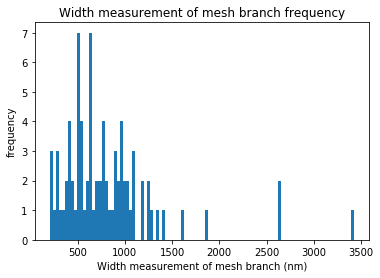

In [27]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,1)
bins = plt.hist(np.array(total_widths),bins=100)
ax.set_xlabel("Width measurement of mesh branch (nm)")
ax.set_ylabel("frequency")
ax.set_title("Width measurement of mesh branch frequency")
plt.show()

In [28]:
sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes,
                          other_meshes_colors="random",
                          other_skeletons=total_branch_skeletons,
                          other_skeletons_colors="random",
                          #html_path="two_soma_mesh_skeleton_decomp.html"
                          )

In [29]:
np.argmax([1,4,5,6])

3

In [30]:

sk.graph_skeleton_and_mesh(other_meshes=[total_branch_meshes[47]],
                          other_meshes_colors="random",
                          other_skeletons=[total_branch_skeletons[47]],
                          other_skeletons_colors="random",
                          html_path="two_soma_mesh_skeleton_decomp.html")

In [174]:
ex_concept_graph[0]

In [179]:
xu = reload(xu)
xu.get_node_attributes(ex_concept_graph[0],attribute_name="endpoints",node_list=[24],
                       return_array=False)

{24: array([[985999. , 911980. , 800972. ],
        [987284.1, 907570.1, 801228.2]])}

In [172]:
xu = reload(xu)
xu.get_all_nodes_with_certain_attribute_key(ex_concept_graph[0],"endpoints")

{24: array([[985999. , 911980. , 800972. ],
        [987284.1, 907570.1, 801228.2]]),
 4: array([[962323.2, 944461.8, 790311.2],
        [985999. , 911980. , 800972. ]]),
 27: array([[985999., 911980., 800972.],
        [987046., 918697., 806237.]]),
 21: array([[984447., 920973., 809177.],
        [987046., 918697., 806237.]]),
 25: array([[985659., 927319., 807214.],
        [987046., 918697., 806237.]]),
 29: array([[ 987046.,  918697.,  806237.],
        [1021340.,  930112.,  812134.]]),
 16: array([[983350., 921859., 812919.],
        [984447., 920973., 809177.]]),
 18: array([[983197., 928592., 817636.],
        [984447., 920973., 809177.]]),
 22: array([[985199., 932788., 807874.],
        [985659., 927319., 807214.]]),
 50: array([[985659. , 927319. , 807214. ],
        [987315.8, 927318.9, 807737.4]]),
 42: array([[1021340. ,  930112. ,  812134. ],
        [1021348. ,  927647.4,  809386.5]]),
 43: array([[1021340.,  930112.,  812134.],
        [1027520.,  938035.,  810200.]]),

In [165]:
ex_concept_graph = limb_concept_networkx[0]
ex_concept_graph[0].

In [181]:


    
    
output_dicts = get_starting_info_from_concept_graph(ex_concept_graph)
output_dicts


[{'starting_soma': 0,
  'starting_node': 24,
  'starting_coordinate': array([987284.1, 907570.1, 801228.2]),
  'starting_endpoints': array([[985999. , 911980. , 800972. ],
         [987284.1, 907570.1, 801228.2]])}]

# PART 3: LAST PART OF ANALYSIS WHERE MAKES CONCEPT GRAPHS

In [156]:
import neuron
neuron = reload(neuron)
nu = reload(nu)
sk = reload(sk)

#getting mesh and skeleton dictionaries
limb_idx_to_branch_meshes_dict = dict()
limb_idx_to_branch_skeletons_dict = dict()
for k in limb_correspondence.keys():
    limb_idx_to_branch_meshes_dict[k] = [limb_correspondence[k][j]["branch_mesh"] for j in limb_correspondence[k].keys()]
    limb_idx_to_branch_skeletons_dict[k] = [limb_correspondence[k][j]["branch_skeleton"] for j in limb_correspondence[k].keys()]      

#getting the soma dictionaries
soma_idx_to_mesh_dict = dict()
for k,v in enumerate(current_mesh_data[0]["soma_meshes"]):
    soma_idx_to_mesh_dict[k] = v

soma_idx_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"]



limb_concept_networkx,limb_labels = neuron.generate_limb_concept_networks_from_global_connectivity(
    limb_idx_to_branch_meshes_dict = limb_idx_to_branch_meshes_dict,
    limb_idx_to_branch_skeletons_dict = limb_idx_to_branch_skeletons_dict,
    soma_idx_to_mesh_dict = soma_idx_to_mesh_dict,
    soma_idx_connectivity = soma_idx_connectivity,
    current_neuron=current_neuron,
    return_limb_labels=True
    )

#Before go and get concept maps:
print("Sizes of dictionaries sent")
for curr_limb in limb_idx_to_branch_skeletons_dict.keys():
    print((len(limb_idx_to_branch_skeletons_dict[curr_limb]),len(limb_idx_to_branch_meshes_dict[curr_limb])))
    
    
print("\n\n Sizes of concept maps gotten back")
for curr_idx in limb_concept_networkx.keys():
    for soma_idx,concept_graph in limb_concept_networkx[curr_idx].items():
        print(len(np.unique(list(concept_graph.nodes()))))



------Working on limb 0 -------
inside loop len(curr_limb_divided_meshes) = 51 len(curr_limb_divided_skeletons) = 51
--- Working on soma_idx: 0----
Total time for filtering periphery meshes = 0.13031601905822754
Total time for mesh mapping: 0.05916762351989746
Total time for mesh mapping: 0.025935649871826172
touching_pieces = [24]
Total time for mesh connectivity = 0.09212994575500488
Touching piece endpoints = [[985999.  911980.  800972. ]
 [987284.1 907570.1 801228.2]]
inside inner loop len(curr_limb_divided_skeletons) = 51
closest_endpoint = [987284.1 907570.1 801228.2]
Starting_edge inside branches_to_conept = [[985999.  911980.  800972. ]
 [987284.1 907570.1 801228.2]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [26]
printing out current edge:
[[987284.1 907570.1 801228.2]
 [985999.  911980.  800972. ]]
edge_endpoints_to_process was empty so exiting loop after 51 iterations
starting_node in concept map (that should match the 

Total time for filtering periphery meshes = 0.06749200820922852
Total time for mesh mapping: 0.060410261154174805
touching_pieces = [20]
Total time for mesh connectivity = 0.06817245483398438
Touching piece endpoints = [[ 984449.   890050.   802922. ]
 [1018642.   882807.4  839586.8]]
inside inner loop len(curr_limb_divided_skeletons) = 23
closest_endpoint = [984449. 890050. 802922.]
Starting_edge inside branches_to_conept = [[ 984449.   890050.   802922. ]
 [1018642.   882807.4  839586.8]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [21]
printing out current edge:
[[ 984449.   890050.   802922. ]
 [1018642.   882807.4  839586.8]]
edge_endpoints_to_process was empty so exiting loop after 23 iterations
starting_node in concept map (that should match the starting edge) = 20
Total time for branches to concept conversion = 0.1008155345916748

recovered_touching_piece = [20]
After concept mapping size = 23
original_branch_endpoints = [[87

# the final data that will be ported over to the Neuron class

In [ ]:
current_mesh_data[0]

In [32]:

current_neuron
"""
whole neuron to be used for other processing
"""

# The 0 at the front is to say it is the first seperated mesh containing somas (could be multiple)
current_mesh_data[0].keys()
"""
soma_meshes
soma_to_piece_connectivity
"""
"""
limb_correspondence[0][0].keys() --> the exact limb and the exact branch

AKA [limb_idx][branch_idx]

"""
limb_correspondence[0][0]["branch_skeleton"]
limb_correspondence[0][0]["width_from_skeleton"]
limb_correspondence[0][0]["branch_mesh"]
limb_correspondence[0][0]["branch_face_idx"]



limb_concept_networkx
limb_labels


#things that weren't used in classification but still would have knowledge of:
insignificant_limbs # the limbs that were filtered away after did soma subtraction because not big enough
print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")# meshes that were seperate from soma mesh
print(f"# of inside pieces = {len(inside_pieces)}") #inside of the soma meshes
"""
Concept networks for limbs and labels of all limbs
"""

# of non soma touching seperate meshes = 4
# of inside pieces = 4


'\nConcept networks for limbs and labels of all limbs\n'

# Application: Practice Turning Into an Object

total_edges = [['S0', 'L0'], ['S0', 'L1'], ['S0', 'L2']]


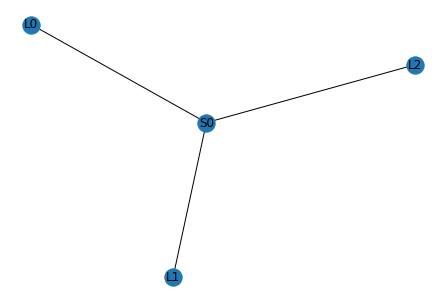

In [83]:
def convert_soma_to_piece_connectivity_to_graph(soma_to_piece_connectivity):
    """
    Pseudocode: 
    1) Create the edges with the new names from the soma_to_piece_connectivity
    2) Create a GraphOrderedEdges from the new edges
    """
    
    total_edges = []
    for soma_key,list_of_limbs in soma_to_piece_connectivity.items():
        total_edges += [[f"S{soma_key}",f"L{curr_limb}"] for curr_limb in list_of_limbs]
    
    print(f"total_edges = {total_edges}")
    concept_graph = xu.GraphOrderedEdges()
    concept_graph.add_edges_from(total_edges)
    return concept_graph


# Application: Creating the Neuron Object

In [ ]:
from neuron import *

"""
Pseudocode: 
1) Create Neuron Object (through __init__)
a. Add the small non_soma_list_meshes
b. Add whole mesh
c. Add soma_to_piece_connectivity as concept graph and it will be turned into a concept map

2) Creat the soma meshes
a. Create soma mesh objects
b. Add the soma objects as ["data"] attribute of all of the soma nodes

3) Limb Process: For each limb (use an index to iterate through limb_correspondence,current_mesh_data and limb_concept_graph/lables) 
a. Build all the branches from the 
    - mesh
    - skeleton
    - width
    - branch_face_idx
b. Pick the top concept graph (will use to store the nodes)
c. Put the branches as "data" in the network
d. Get all of the starting coordinates and starting edges and put as member attributes in the limb



"""

# Plotting for visualizataions (used for platinum update report)

In [33]:
curr_limb_idx = 2

In [34]:
#plotting the mesh
sk = reload(sk)
mu = reload(mu)
random_colors_used = sk.graph_skeleton_and_mesh(
    other_meshes=[v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_meshes_colors="random",
                          other_skeletons=[v["branch_skeleton"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_skeletons_colors="random",
                            mesh_alpha=0.8,
                          return_other_colors=True)
random_colors_used_no_alpha = random_colors_used[:,:-1]

In [35]:
#plotting the skeleton
sk = reload(sk)
mu = reload(mu)
sk.graph_skeleton_and_mesh(#other_meshes=total_branch_meshes[:node_to_check_to],
                          #other_meshes_colors="random",
                          other_skeletons=[v["branch_skeleton"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_skeletons_colors="random",
                            mesh_alpha=0.05)


In [36]:
# get the label:
limb_labels[curr_limb_idx]

'Normal'

In [37]:
limb_concept_networkx

{0: {0: <networkx_utils.GraphOrderedEdges at 0x7f66f27c5c88>},
 1: {0: <networkx_utils.GraphOrderedEdges at 0x7f66f2f5ed30>},
 2: {0: <networkx_utils.GraphOrderedEdges at 0x7f66f312f0f0>}}

In [38]:
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    print((len(np.unique(list(concept_graph.nodes()))),len([v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ])))

(7, 7)


Starting from soma index 0 with starting_coordinate and mesh: [[991957. 902000. 793498.]]


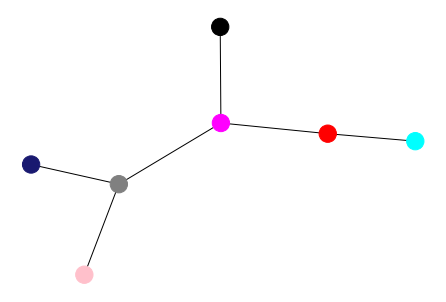

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    print(f"Starting from soma index {soma_idx} with starting_coordinate and mesh: "
          f"{xu.get_node_attributes(concept_graph,attribute_name='starting_coordinate')}")
    # plotting the concept network with the same colors
    nx.draw(concept_graph,node_color=random_colors_used_no_alpha) 
    plt.show()
    print("\n\n")

In [40]:
# Try plotting the points in 3D: random_colors_used = sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes[:node_to_check_to],
mesh_midpoints =  [np.array([np.mean(k.vertices,axis=0)]) for k in [v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ]]
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    graph_nodes_skeleton = np.array(mesh_midpoints)[concept_graph.edges_ordered()].reshape(-1,2,3)
    [k for k in graph_nodes_skeleton]
    random_colors_used[:,-1] = 1


    sk.graph_skeleton_and_mesh(other_scatter=mesh_midpoints,
                              other_scatter_colors=random_colors_used,
                              other_skeletons=graph_nodes_skeleton,
                              other_skeletons_colors="black",
                                                   scatter_size=3)



In [41]:


    
# Try plotting the points in 3D: random_colors_used = sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes[:node_to_check_to],
mesh_midpoints =  [np.array([np.mean(k.vertices,axis=0)]) for k in [v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ]]
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    graph_nodes_skeleton = np.array(mesh_midpoints)[concept_graph.edges_ordered()].reshape(-1,2,3)
    [k for k in graph_nodes_skeleton]
    random_colors_used[:,-1] = 1


    sk.graph_skeleton_and_mesh(
        other_meshes=[v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_meshes_colors="random",other_scatter=mesh_midpoints,
                              other_scatter_colors=random_colors_used,
                              other_skeletons=graph_nodes_skeleton,
                              other_skeletons_colors="black",
                                                   scatter_size=1)

# Will look at everything with soma

In [47]:
#list(itertools.chain([[1,4,5],[4,5,6]]))

<trimesh.Trimesh(vertices.shape=(11064, 3), faces.shape=(21944, 3))>

In [160]:
all_branch_meshes = list(itertools.chain.from_iterable([[v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items()] for curr_limb_idx in limb_correspondence.keys() ]))
#plotting the mesh
soma_meshes_comb = tu.combine_meshes(current_mesh_data[0]["soma_meshes"])
random_colors_used = sk.graph_skeleton_and_mesh(
    main_mesh_verts=soma_meshes_comb.vertices,
    main_mesh_faces=soma_meshes_comb.faces,
    main_mesh_color="red",
    other_meshes=all_branch_meshes,
    other_meshes_colors="random",
    other_skeletons=list(itertools.chain.from_iterable([[v["branch_skeleton"] for k,v in limb_correspondence[curr_limb_idx].items()] for curr_limb_idx in limb_correspondence.keys() ])),
    other_skeletons_colors="random",
    mesh_alpha=0.2,
    return_other_colors=True,
    html_path=f"./visualizations/{segment_id}_small_interneuron_mesh_skeleton.html")
random_colors_used_no_alpha = random_colors_used[:,:-1]

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# graph all of the concept map

In [162]:
# Try plotting the points in 3D: random_colors_used = sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes[:node_to_check_to],
total_graph_nodes_skeletons = []
total_mesh_midpoints = []
for curr_limb_idx in limb_concept_networkx.keys():
    mesh_midpoints =  [np.array([np.mean(k.vertices,axis=0)]) for k in [v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ]]
    total_mesh_midpoints.append(mesh_midpoints)
    for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
        graph_nodes_skeleton = np.array(mesh_midpoints)[concept_graph.edges_ordered()].reshape(-1,2,3)
        total_graph_nodes_skeletons.append(graph_nodes_skeleton)
        break
random_colors_used_copy = random_colors_used.copy()
random_colors_used[:,-1] = 1

total_mesh_midpoints = list(itertools.chain.from_iterable(total_mesh_midpoints))
#total_graph_nodes_skeletons = sk.stack_skeletons(total_graph_nodes_skeletons)

sk.graph_skeleton_and_mesh(
    main_mesh_verts=soma_meshes_comb.vertices,
    main_mesh_faces=soma_meshes_comb.faces,
    main_mesh_color="red",
#     other_meshes=all_branch_meshes,
#     other_meshes_colors=random_colors_used_copy,
    other_scatter=total_mesh_midpoints,
    other_scatter_colors=random_colors_used,
    other_skeletons=total_graph_nodes_skeletons,
    other_skeletons_colors="random",
    scatter_size=1,
    html_path=f"./visualizations/{segment_id}_small_interneuron_mesh_concept_graph.html")